In [1]:
# Crisis Shock Vector Analysis and Portfolio P&L Mapping
# Extension to project02_quant_analysis.ipynb

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

In [2]:
# Load all data sheets (same as project02)
excel_path = 'dataset/LTCM_database.xlsx'
dfs = pd.read_excel(excel_path, sheet_name=None)

# Create dataframe with all time series
data_dict = {}

for sheet, df in dfs.items():
    if sheet.strip().lower() == 'master list':
        continue
    
    df.columns = [col.strip().lower() for col in df.columns]
    date_col = df.columns[0]
    
    df[date_col] = pd.to_datetime(df[date_col], format='%m/%d/%Y', errors='coerce')
    df = df.dropna(subset=[date_col])
    df = df.sort_values(by=date_col)
    df = df.set_index(date_col)
    
    clean_name = sheet.strip()
    data_dict[clean_name] = df.iloc[:, 0]

df_master = pd.DataFrame(data_dict)

# Filter for LTCM period
ltcm_period = (df_master.index >= '1995-01-01') & (df_master.index <= '1998-12-31')
df_ltcm = df_master[ltcm_period].copy()

# Calculate returns
returns_series = {}
returns_series['R_credit'] = df_ltcm['Bloomberg US Aggregate Total Re'].pct_change()
returns_series['R_treasury'] = df_ltcm['Bloomberg U.S. Treasury  20+ Ye'].pct_change()
returns_series['R_em'] = df_ltcm['JPMorgan EMBI Global Diversifie'].pct_change()
returns_series['R_vol'] = df_ltcm['Volatility Index'].pct_change()
returns_series['R_f'] = df_ltcm['US Treasury 3-Month Yield'] / 100 / 252

df_returns = pd.DataFrame(returns_series).dropna()

# Portfolio weights (from project02)
w_credit = 0.50
w_treasury = -0.30
w_em = 0.30
w_vol = -0.50
L = 25

# Calculate portfolio returns
df_returns['R_p'] = (w_credit * df_returns['R_credit'] + 
                     w_treasury * df_returns['R_treasury'] + 
                     w_em * df_returns['R_em'] +
                     w_vol * df_returns['R_vol'])

df_returns['R_p_L'] = L * df_returns['R_p'] - (L - 1) * df_returns['R_f']

print("Data loaded and portfolio returns calculated")
print(f"Period: {df_returns.index.min()} to {df_returns.index.max()}")
print(f"Total observations: {len(df_returns)}")

Data loaded and portfolio returns calculated
Period: 1995-01-04 00:00:00 to 1998-12-31 00:00:00
Total observations: 1011


In [3]:
# CRISIS SHOCK VECTOR ANALYSIS
# Define crisis period
crisis_start = pd.Timestamp('1998-08-01')
crisis_end = pd.Timestamp('1998-10-31')
crisis_mask = (df_returns.index >= crisis_start) & (df_returns.index <= crisis_end)

# Pre-crisis baseline (1996-1997)
baseline_start = pd.Timestamp('1996-01-01')
baseline_end = pd.Timestamp('1997-12-31')
baseline_mask = (df_returns.index >= baseline_start) & (df_returns.index <= baseline_end)

print("="*80)
print("CRISIS SHOCK VECTOR EXTRACTION")
print("="*80)

CRISIS SHOCK VECTOR EXTRACTION


In [4]:
# 1. SPREAD SHOCK ANALYSIS
# Calculate spread levels (using actual spread data)
spread_credit = df_ltcm['Credit Spread Risk']
spread_em = df_ltcm['JPMorgan EMBI Global Diversifie']

# Baseline spreads (pre-crisis average)
baseline_credit_spread = spread_credit[baseline_start:baseline_end].mean()
baseline_em_spread = spread_em[baseline_start:baseline_end].mean()

# Crisis peak spreads
crisis_credit_spread_max = spread_credit[crisis_start:crisis_end].max()
crisis_em_spread_max = spread_em[crisis_start:crisis_end].max()

# Spread shocks (widening in basis points)
spread_shock_credit = crisis_credit_spread_max - baseline_credit_spread
spread_shock_em = crisis_em_spread_max - baseline_em_spread

# Spread shock in percentage terms
spread_shock_credit_pct = (spread_shock_credit / baseline_credit_spread) * 100
spread_shock_em_pct = (spread_shock_em / baseline_em_spread) * 100

print("\nSPREAD SHOCK VECTORS:")
print(f"  Credit Spread:")
print(f"    Baseline: {baseline_credit_spread:.2f} bps")
print(f"    Crisis Peak: {crisis_credit_spread_max:.2f} bps")
print(f"    Shock: +{spread_shock_credit:.2f} bps ({spread_shock_credit_pct:+.1f}%)")
print(f"\n  EM Spread:")
print(f"    Baseline: {baseline_em_spread:.2f} bps")
print(f"    Crisis Peak: {crisis_em_spread_max:.2f} bps")
print(f"    Shock: +{spread_shock_em:.2f} bps ({spread_shock_em_pct:+.1f}%)")


SPREAD SHOCK VECTORS:
  Credit Spread:
    Baseline: 851.45 bps
    Crisis Peak: 1030.73 bps
    Shock: +179.28 bps (+21.1%)

  EM Spread:
    Baseline: 136.75 bps
    Crisis Peak: 157.17 bps
    Shock: +20.42 bps (+14.9%)


In [5]:
# 2. CORRELATION BREAKDOWN ANALYSIS
# Calculate rolling correlation between key assets
rolling_window = 60

# Pre-crisis correlation
corr_baseline = df_returns.loc[baseline_mask, ['R_credit', 'R_treasury', 'R_em', 'R_vol']].corr()

# Crisis correlation
corr_crisis = df_returns.loc[crisis_mask, ['R_credit', 'R_treasury', 'R_em', 'R_vol']].corr()

# Key correlation pairs for LTCM strategy
key_pairs = [
    ('R_credit', 'R_treasury'),
    ('R_credit', 'R_em'),
    ('R_em', 'R_treasury'),
    ('R_vol', 'R_credit')
]

print("\nCORRELATION BREAKDOWN VECTORS:")
correlation_changes = []
for pair in key_pairs:
    baseline_corr = corr_baseline.loc[pair[0], pair[1]]
    crisis_corr = corr_crisis.loc[pair[0], pair[1]]
    corr_shock = crisis_corr - baseline_corr
    
    correlation_changes.append({
        'Asset Pair': f"{pair[0].replace('R_', '')} vs {pair[1].replace('R_', '')}",
        'Baseline Correlation': baseline_corr,
        'Crisis Correlation': crisis_corr,
        'Correlation Shock': corr_shock
    })
    
    print(f"  {pair[0].replace('R_', '').upper()} vs {pair[1].replace('R_', '').upper()}:")
    print(f"    Baseline: {baseline_corr:.3f}")
    print(f"    Crisis: {crisis_corr:.3f}")
    print(f"    Shock: {corr_shock:+.3f}")

df_correlation_shocks = pd.DataFrame(correlation_changes)


CORRELATION BREAKDOWN VECTORS:
  CREDIT vs TREASURY:
    Baseline: 0.982
    Crisis: 0.943
    Shock: -0.038
  CREDIT vs EM:
    Baseline: 0.378
    Crisis: -0.307
    Shock: -0.685
  EM vs TREASURY:
    Baseline: 0.364
    Crisis: -0.265
    Shock: -0.629
  VOL vs CREDIT:
    Baseline: -0.323
    Crisis: 0.384
    Shock: +0.707


In [6]:
# 3. VOLATILITY SHOCK ANALYSIS
# Calculate volatility for each component
vol_baseline = {}
vol_crisis = {}
vol_shocks = {}

components = {
    'Credit': 'R_credit',
    'Treasury': 'R_treasury',
    'EM': 'R_em',
    'Volatility': 'R_vol',
    'Portfolio': 'R_p_L'
}

print("\nVOLATILITY SHOCK VECTORS (Annualized %):")
for name, col in components.items():
    # Baseline volatility (annualized)
    vol_base = df_returns.loc[baseline_mask, col].std() * np.sqrt(252) * 100
    
    # Crisis volatility (annualized)
    vol_cris = df_returns.loc[crisis_mask, col].std() * np.sqrt(252) * 100
    
    # Volatility shock
    vol_shock = vol_cris - vol_base
    vol_shock_pct = (vol_shock / vol_base) * 100
    
    vol_baseline[name] = vol_base
    vol_crisis[name] = vol_cris
    vol_shocks[name] = vol_shock
    
    print(f"  {name}:")
    print(f"    Baseline: {vol_base:.2f}%")
    print(f"    Crisis: {vol_cris:.2f}%")
    print(f"    Shock: +{vol_shock:.2f}% ({vol_shock_pct:+.1f}%)")


VOLATILITY SHOCK VECTORS (Annualized %):
  Credit:
    Baseline: 4.00%
    Crisis: 4.54%
    Shock: +0.54% (+13.4%)
  Treasury:
    Baseline: 9.32%
    Crisis: 11.47%
    Shock: +2.15% (+23.1%)
  EM:
    Baseline: 11.22%
    Crisis: 33.43%
    Shock: +22.21% (+198.1%)
  Volatility:
    Baseline: 86.95%
    Crisis: 128.21%
    Shock: +41.26% (+47.5%)
  Portfolio:
    Baseline: 1122.84%
    Crisis: 1757.51%
    Shock: +634.68% (+56.5%)


In [7]:
# 4. PORTFOLIO P&L ATTRIBUTION DURING CRISIS
# Calculate component-level P&L contribution during crisis

# Daily component contributions (leveraged)
df_returns['PnL_credit'] = L * w_credit * df_returns['R_credit']
df_returns['PnL_treasury'] = L * w_treasury * df_returns['R_treasury']
df_returns['PnL_em'] = L * w_em * df_returns['R_em']
df_returns['PnL_vol'] = L * w_vol * df_returns['R_vol']
df_returns['PnL_financing'] = -(L - 1) * df_returns['R_f']

# Crisis period P&L
crisis_pnl = df_returns.loc[crisis_mask]

# Cumulative P&L during crisis
cumulative_pnl = {
    'Credit': crisis_pnl['PnL_credit'].sum() * 100,
    'Treasury': crisis_pnl['PnL_treasury'].sum() * 100,
    'EM': crisis_pnl['PnL_em'].sum() * 100,
    'Volatility': crisis_pnl['PnL_vol'].sum() * 100,
    'Financing Cost': crisis_pnl['PnL_financing'].sum() * 100,
    'Total': crisis_pnl['R_p_L'].sum() * 100
}

print("\nCRISIS P&L ATTRIBUTION (Aug-Oct 1998):")
print("="*60)
for component, pnl in cumulative_pnl.items():
    print(f"  {component:20s}: {pnl:+8.2f}%")
print("="*60)

# Worst single-day loss
worst_day = crisis_pnl['R_p_L'].idxmin()
worst_loss = crisis_pnl.loc[worst_day, 'R_p_L'] * 100

print(f"\nWorst Single-Day Loss: {worst_loss:.2f}% on {worst_day.strftime('%Y-%m-%d')}")


CRISIS P&L ATTRIBUTION (Aug-Oct 1998):
  Credit              :   +45.86%
  Treasury            :   -45.31%
  EM                  :   -94.08%
  Volatility          :  -266.93%
  Financing Cost      :   -33.39%
  Total               :  -393.86%

Worst Single-Day Loss: -346.38% on 1998-08-27


In [8]:
# 5. CONSOLIDATED CRISIS SHOCK TABLE
# Build comprehensive shock-to-P&L mapping table

shock_table_data = []

# Spread shocks
shock_table_data.append({
    'Shock Type': 'Spread Widening',
    'Asset/Factor': 'Credit (High-Yield)',
    'Baseline': f'{baseline_credit_spread:.0f} bps',
    'Crisis Peak': f'{crisis_credit_spread_max:.0f} bps',
    'Shock Magnitude': f'+{spread_shock_credit:.0f} bps ({spread_shock_credit_pct:+.0f}%)',
    'Portfolio Exposure': f'{w_credit*L*100:+.0f}% (Long)',
    'P&L Impact': f'{cumulative_pnl["Credit"]:.2f}%'
})

shock_table_data.append({
    'Shock Type': 'Spread Widening',
    'Asset/Factor': 'Emerging Markets',
    'Baseline': f'{baseline_em_spread:.0f} bps',
    'Crisis Peak': f'{crisis_em_spread_max:.0f} bps',
    'Shock Magnitude': f'+{spread_shock_em:.0f} bps ({spread_shock_em_pct:+.0f}%)',
    'Portfolio Exposure': f'{w_em*L*100:+.0f}% (Long)',
    'P&L Impact': f'{cumulative_pnl["EM"]:.2f}%'
})

# Volatility shocks
for name, col in [('Credit', 'R_credit'), ('EM', 'R_em'), ('Volatility Index', 'R_vol')]:
    exposure = {'Credit': w_credit*L, 'EM': w_em*L, 'Volatility Index': w_vol*L}[name]
    pnl_impact = {'Credit': cumulative_pnl['Credit'], 
                  'EM': cumulative_pnl['EM'], 
                  'Volatility Index': cumulative_pnl['Volatility']}[name]
    
    shock_table_data.append({
        'Shock Type': 'Volatility Spike',
        'Asset/Factor': name,
        'Baseline': f'{vol_baseline[name if name != "Volatility Index" else "Volatility"]:.1f}%',
        'Crisis Peak': f'{vol_crisis[name if name != "Volatility Index" else "Volatility"]:.1f}%',
        'Shock Magnitude': f'+{vol_shocks[name if name != "Volatility Index" else "Volatility"]:.1f}% ({vol_shocks[name if name != "Volatility Index" else "Volatility"]/vol_baseline[name if name != "Volatility Index" else "Volatility"]*100:+.0f}%)',
        'Portfolio Exposure': f'{exposure*100:+.0f}%',
        'P&L Impact': f'{pnl_impact:.2f}%'
    })

# Correlation breakdown shocks
for idx, row in df_correlation_shocks.iterrows():
    shock_table_data.append({
        'Shock Type': 'Correlation Breakdown',
        'Asset/Factor': row['Asset Pair'],
        'Baseline': f'{row["Baseline Correlation"]:.3f}',
        'Crisis Peak': f'{row["Crisis Correlation"]:.3f}',
        'Shock Magnitude': f'{row["Correlation Shock"]:+.3f}',
        'Portfolio Exposure': 'Cross-Asset',
        'P&L Impact': 'Indirect (Diversification Loss)'
    })

df_consolidated_shocks = pd.DataFrame(shock_table_data)

print("\n" + "="*120)
print("CONSOLIDATED CRISIS SHOCK VECTORS → PORTFOLIO P&L MAPPING")
print("="*120)
print(df_consolidated_shocks.to_string(index=False))
print("="*120)


CONSOLIDATED CRISIS SHOCK VECTORS → PORTFOLIO P&L MAPPING
           Shock Type        Asset/Factor Baseline Crisis Peak Shock Magnitude Portfolio Exposure                      P&L Impact
      Spread Widening Credit (High-Yield)  851 bps    1031 bps +179 bps (+21%)      +1250% (Long)                          45.86%
      Spread Widening    Emerging Markets  137 bps     157 bps  +20 bps (+15%)       +750% (Long)                         -94.08%
     Volatility Spike              Credit     4.0%        4.5%    +0.5% (+13%)             +1250%                          45.86%
     Volatility Spike                  EM    11.2%       33.4%  +22.2% (+198%)              +750%                         -94.08%
     Volatility Spike    Volatility Index    87.0%      128.2%   +41.3% (+47%)             -1250%                        -266.93%
Correlation Breakdown  credit vs treasury    0.982       0.943          -0.038        Cross-Asset Indirect (Diversification Loss)
Correlation Breakdown        cr

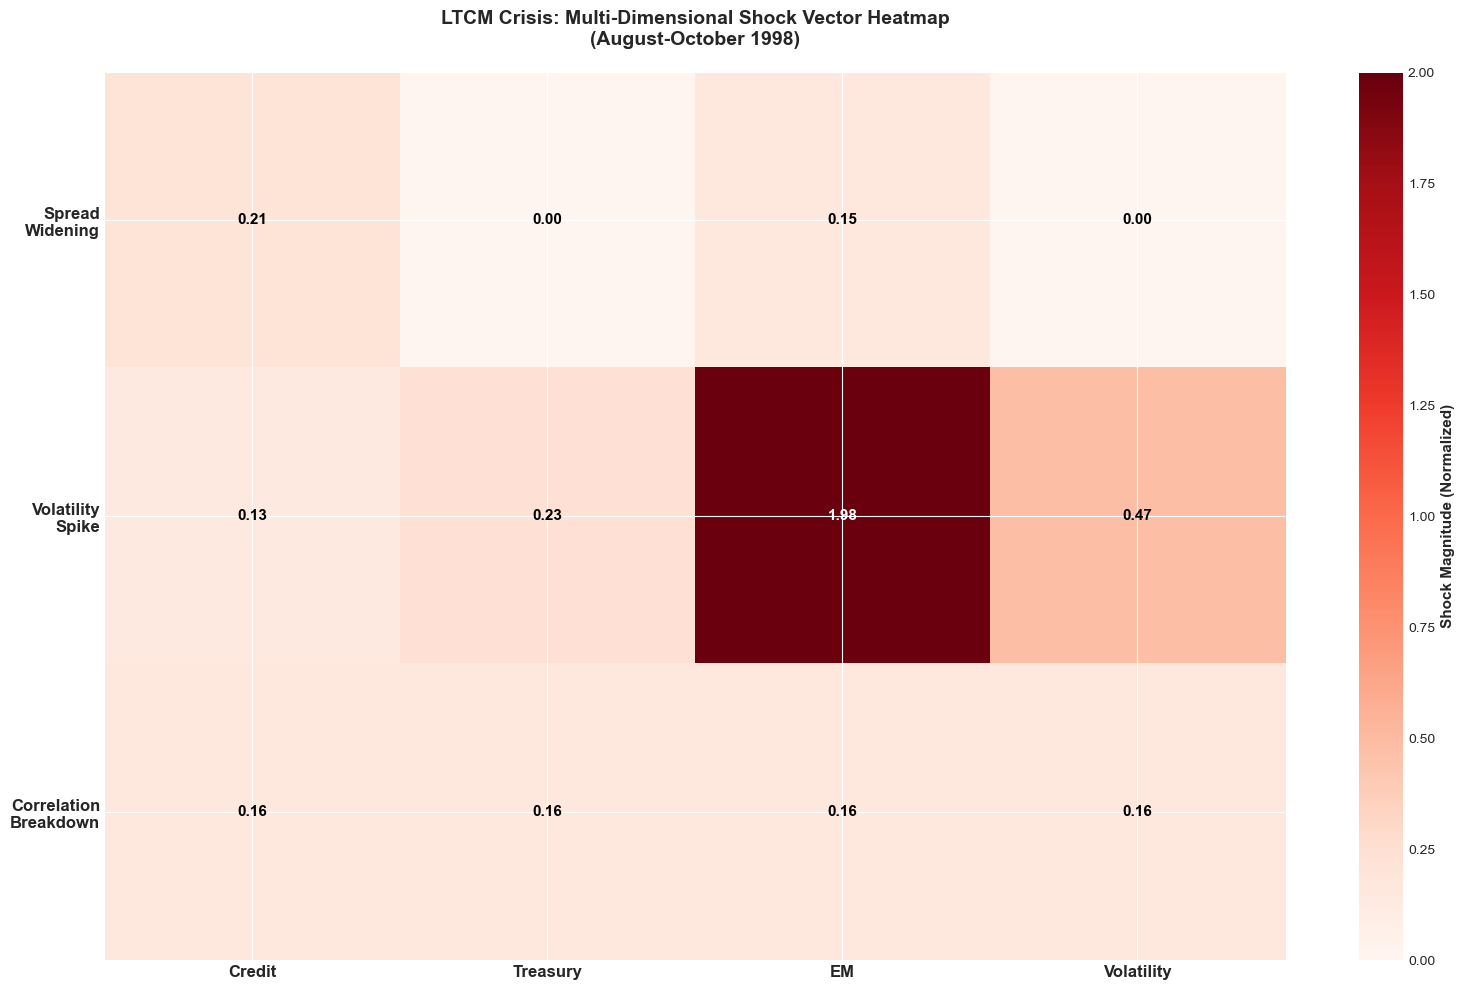

Figure saved: figs/crisis_shock_heatmap.png


In [9]:
# VISUALIZATION 1: Crisis Shock Vector Heatmap
fig, ax = plt.subplots(figsize=(16, 10))

# Prepare data for heatmap
shock_categories = ['Spread\nWidening', 'Volatility\nSpike', 'Correlation\nBreakdown']
asset_classes = ['Credit', 'Treasury', 'EM', 'Volatility']

# Build shock magnitude matrix
shock_matrix = np.zeros((len(shock_categories), len(asset_classes)))

# Spread shocks (normalized)
shock_matrix[0, 0] = spread_shock_credit_pct / 100  # Credit
shock_matrix[0, 2] = spread_shock_em_pct / 100      # EM

# Volatility shocks (normalized)
for i, name in enumerate(asset_classes):
    if name in vol_shocks:
        shock_matrix[1, i] = vol_shocks[name] / vol_baseline[name]

# Correlation shocks (average absolute change)
avg_corr_shock = abs(df_correlation_shocks['Correlation Shock'].mean())
shock_matrix[2, :] = avg_corr_shock

# Create heatmap
im = ax.imshow(shock_matrix, cmap='Reds', aspect='auto', vmin=0, vmax=2)

# Set ticks and labels
ax.set_xticks(np.arange(len(asset_classes)))
ax.set_yticks(np.arange(len(shock_categories)))
ax.set_xticklabels(asset_classes, fontsize=12, fontweight='bold')
ax.set_yticklabels(shock_categories, fontsize=12, fontweight='bold')

# Add colorbar
cbar = plt.colorbar(im, ax=ax)
cbar.set_label('Shock Magnitude (Normalized)', fontsize=11, fontweight='bold')

# Annotate cells with values
for i in range(len(shock_categories)):
    for j in range(len(asset_classes)):
        text = ax.text(j, i, f'{shock_matrix[i, j]:.2f}',
                      ha="center", va="center", color="white" if shock_matrix[i, j] > 1 else "black",
                      fontsize=11, fontweight='bold')

ax.set_title('LTCM Crisis: Multi-Dimensional Shock Vector Heatmap\n(August-October 1998)', 
             fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.savefig('figs/crisis_shock_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()

print("Figure saved: figs/crisis_shock_heatmap.png")

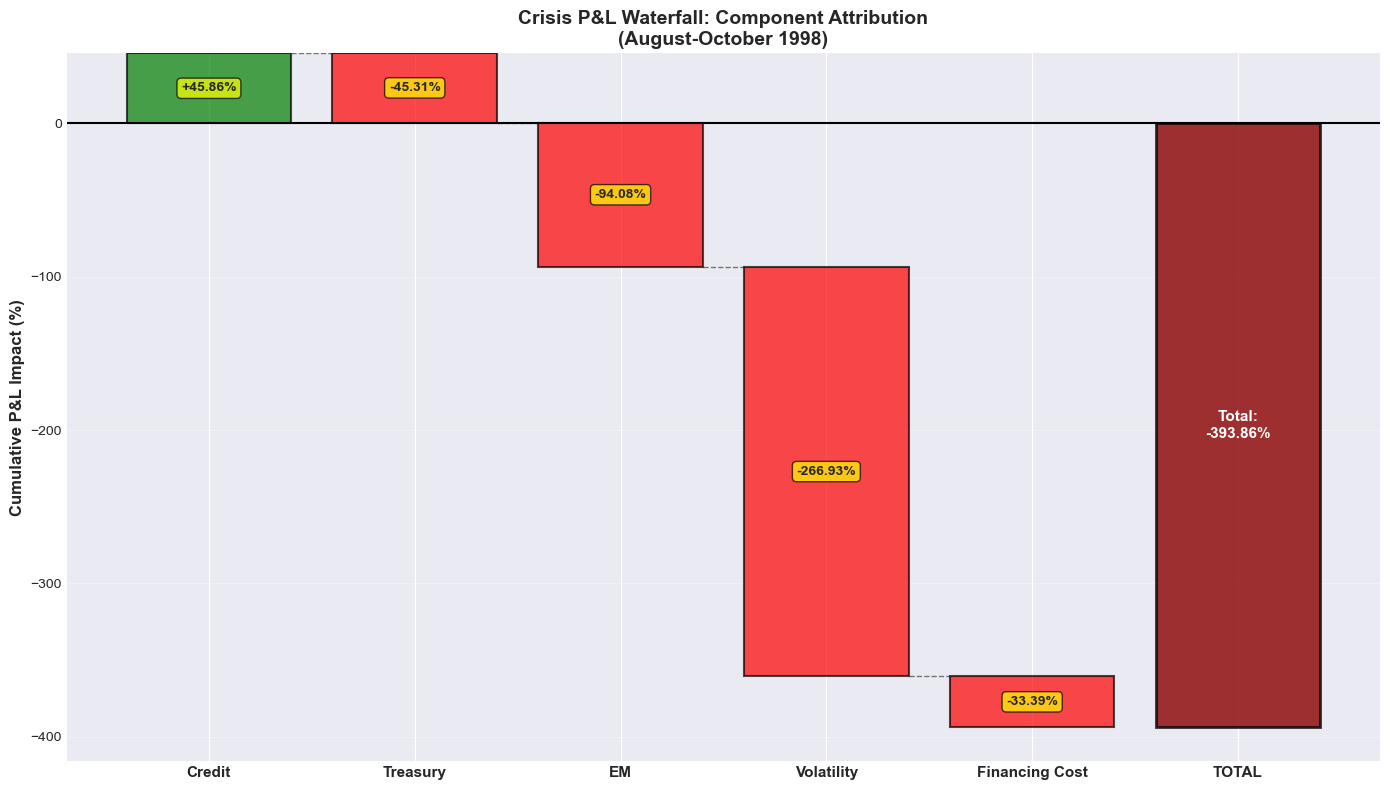

Figure saved: figs/crisis_pnl_waterfall.png


In [10]:
# VISUALIZATION 2: Shock-to-P&L Waterfall Chart
fig, ax = plt.subplots(figsize=(14, 8))

# P&L components
components_list = ['Credit', 'Treasury', 'EM', 'Volatility', 'Financing Cost']
pnl_values = [cumulative_pnl[c] for c in components_list]

# Calculate cumulative for waterfall
cumulative = [0]
for val in pnl_values:
    cumulative.append(cumulative[-1] + val)

# Colors
colors = ['red' if val < 0 else 'green' for val in pnl_values]

# Plot bars
for i, (comp, val) in enumerate(zip(components_list, pnl_values)):
    ax.bar(i, val, bottom=cumulative[i], color=colors[i], alpha=0.7, edgecolor='black', linewidth=1.5)
    
    # Add connector lines
    if i < len(components_list) - 1:
        ax.plot([i + 0.4, i + 0.6], [cumulative[i+1], cumulative[i+1]], 'k--', linewidth=1, alpha=0.5)
    
    # Add value labels
    label_y = cumulative[i] + val/2
    ax.text(i, label_y, f'{val:+.2f}%', ha='center', va='center', 
            fontsize=10, fontweight='bold', 
            bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=0.7))

# Add total bar
total_pnl = cumulative_pnl['Total']
ax.bar(len(components_list), total_pnl, color='darkred', alpha=0.8, edgecolor='black', linewidth=2)
ax.text(len(components_list), total_pnl/2, f'Total:\n{total_pnl:+.2f}%', 
        ha='center', va='center', fontsize=11, fontweight='bold', color='white')

# Formatting
ax.set_xticks(range(len(components_list) + 1))
ax.set_xticklabels(components_list + ['TOTAL'], fontsize=11, fontweight='bold', rotation=0)
ax.set_ylabel('Cumulative P&L Impact (%)', fontsize=12, fontweight='bold')
ax.set_title('Crisis P&L Waterfall: Component Attribution\n(August-October 1998)', 
             fontsize=14, fontweight='bold')
ax.axhline(0, color='black', linewidth=1.5, linestyle='-')
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('figs/crisis_pnl_waterfall.png', dpi=300, bbox_inches='tight')
plt.show()

print("Figure saved: figs/crisis_pnl_waterfall.png")

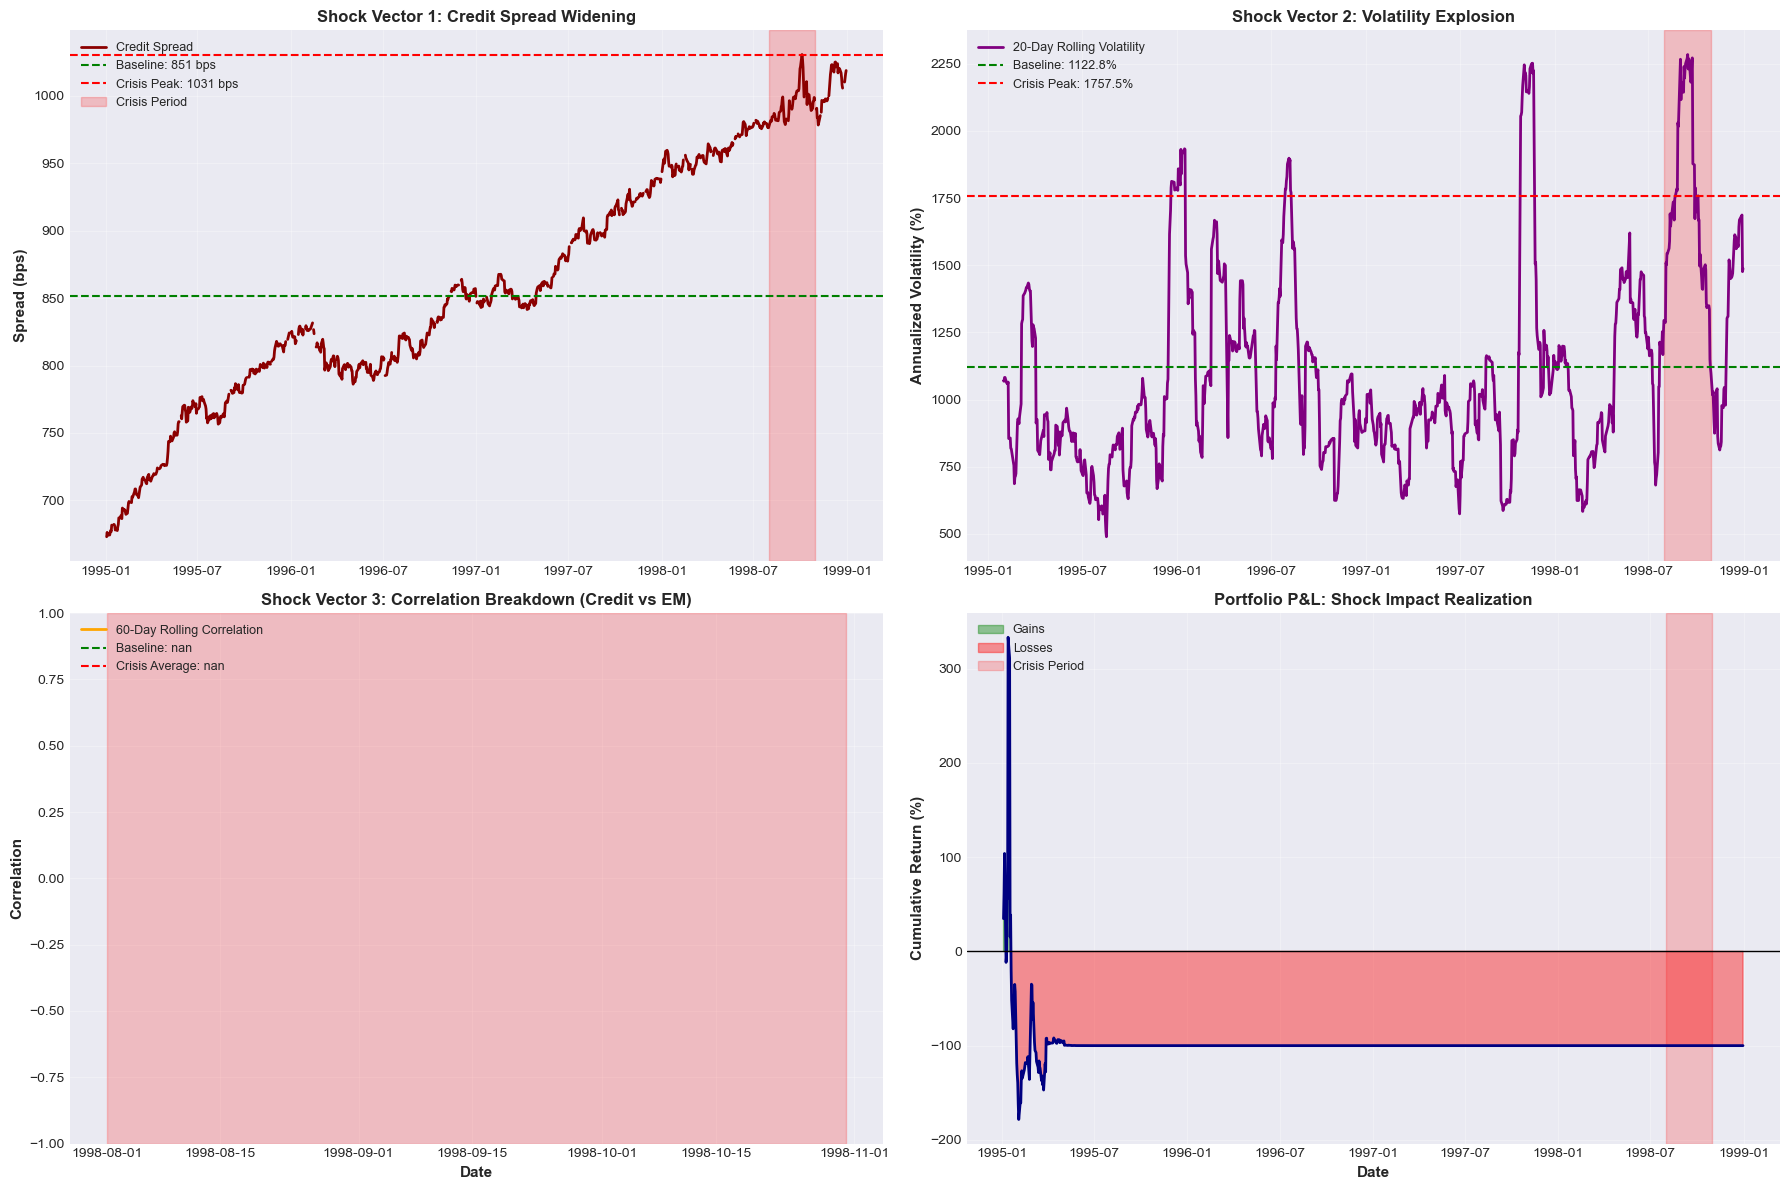

Figure saved: figs/shock_evolution_timeseries.png


In [11]:
# VISUALIZATION 3: Time Series of Shock Evolution
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(18, 12))

# Panel 1: Spread Evolution
ax1.plot(df_ltcm.index, spread_credit, color='darkred', linewidth=2, label='Credit Spread')
ax1.axhline(baseline_credit_spread, color='green', linestyle='--', linewidth=1.5, 
            label=f'Baseline: {baseline_credit_spread:.0f} bps')
ax1.axhline(crisis_credit_spread_max, color='red', linestyle='--', linewidth=1.5,
            label=f'Crisis Peak: {crisis_credit_spread_max:.0f} bps')
ax1.axvspan(crisis_start, crisis_end, alpha=0.2, color='red', label='Crisis Period')
ax1.set_ylabel('Spread (bps)', fontsize=11, fontweight='bold')
ax1.set_title('Shock Vector 1: Credit Spread Widening', fontsize=12, fontweight='bold')
ax1.legend(loc='upper left', fontsize=9)
ax1.grid(True, alpha=0.3)

# Panel 2: Volatility Evolution
rolling_vol_portfolio = df_returns['R_p_L'].rolling(20).std() * np.sqrt(252) * 100
ax2.plot(df_returns.index, rolling_vol_portfolio, color='purple', linewidth=2, label='20-Day Rolling Volatility')
ax2.axhline(vol_baseline['Portfolio'], color='green', linestyle='--', linewidth=1.5,
            label=f'Baseline: {vol_baseline["Portfolio"]:.1f}%')
ax2.axhline(vol_crisis['Portfolio'], color='red', linestyle='--', linewidth=1.5,
            label=f'Crisis Peak: {vol_crisis["Portfolio"]:.1f}%')
ax2.axvspan(crisis_start, crisis_end, alpha=0.2, color='red')
ax2.set_ylabel('Annualized Volatility (%)', fontsize=11, fontweight='bold')
ax2.set_title('Shock Vector 2: Volatility Explosion', fontsize=12, fontweight='bold')
ax2.legend(loc='upper left', fontsize=9)
ax2.grid(True, alpha=0.3)

# Panel 3: Correlation Evolution
rolling_corr = df_ltcm['Credit Spread Risk'].rolling(60).corr(df_ltcm['JPMorgan EMBI Global Diversifie'])
baseline_corr_value = rolling_corr[baseline_start:baseline_end].mean()
crisis_corr_value = rolling_corr[crisis_start:crisis_end].mean()

ax3.plot(df_ltcm.index, rolling_corr, color='orange', linewidth=2, label='60-Day Rolling Correlation')
ax3.axhline(baseline_corr_value, color='green', linestyle='--', linewidth=1.5,
            label=f'Baseline: {baseline_corr_value:.3f}')
ax3.axhline(crisis_corr_value, color='red', linestyle='--', linewidth=1.5,
            label=f'Crisis Average: {crisis_corr_value:.3f}')
ax3.axvspan(crisis_start, crisis_end, alpha=0.2, color='red')
ax3.set_ylabel('Correlation', fontsize=11, fontweight='bold')
ax3.set_xlabel('Date', fontsize=11, fontweight='bold')
ax3.set_title('Shock Vector 3: Correlation Breakdown (Credit vs EM)', fontsize=12, fontweight='bold')
ax3.legend(loc='upper left', fontsize=9)
ax3.grid(True, alpha=0.3)
ax3.set_ylim([-1, 1])

# Panel 4: Cumulative P&L Impact
cumulative_pnl_series = (1 + df_returns['R_p_L']).cumprod() - 1
ax4.fill_between(df_returns.index, cumulative_pnl_series * 100, 0, 
                 where=(cumulative_pnl_series >= 0), color='green', alpha=0.4, label='Gains')
ax4.fill_between(df_returns.index, cumulative_pnl_series * 100, 0,
                 where=(cumulative_pnl_series < 0), color='red', alpha=0.4, label='Losses')
ax4.plot(df_returns.index, cumulative_pnl_series * 100, color='navy', linewidth=2)
ax4.axvspan(crisis_start, crisis_end, alpha=0.2, color='red', label='Crisis Period')
ax4.axhline(0, color='black', linewidth=1)
ax4.set_ylabel('Cumulative Return (%)', fontsize=11, fontweight='bold')
ax4.set_xlabel('Date', fontsize=11, fontweight='bold')
ax4.set_title('Portfolio P&L: Shock Impact Realization', fontsize=12, fontweight='bold')
ax4.legend(loc='upper left', fontsize=9)
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('figs/shock_evolution_timeseries.png', dpi=300, bbox_inches='tight')
plt.show()

print("Figure saved: figs/shock_evolution_timeseries.png")

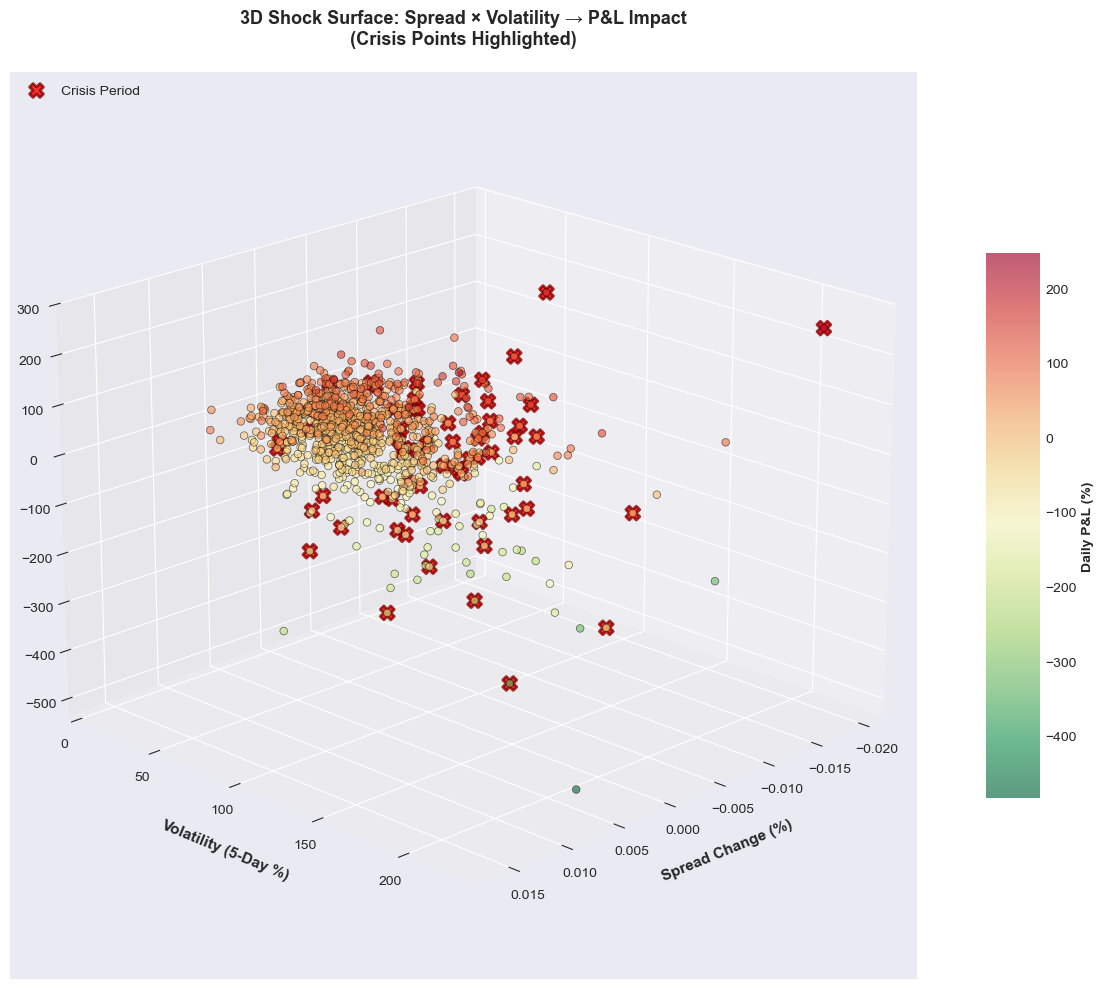

Figure saved: figs/shock_surface_3d.png


In [12]:
# VISUALIZATION 4: 3D Shock Surface (Spread vs Volatility vs P&L)
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(14, 10))
ax = fig.add_subplot(111, projection='3d')

# Prepare data: map spread changes and volatility to daily P&L
# Calculate daily spread changes
spread_credit_aligned = spread_credit.reindex(df_returns.index, method='ffill')
spread_credit_change = spread_credit_aligned.pct_change()

# Daily volatility (rolling 5-day std)
daily_vol = df_returns['R_p_L'].rolling(5).std() * 100

# Remove NaN
plot_data = pd.DataFrame({
    'spread_change': spread_credit_change,
    'volatility': daily_vol,
    'pnl': df_returns['R_p_L'] * 100
}).dropna()

# Scatter plot
scatter = ax.scatter(plot_data['spread_change'], 
                    plot_data['volatility'],
                    plot_data['pnl'],
                    c=plot_data['pnl'], 
                    cmap='RdYlGn_r', 
                    s=30, 
                    alpha=0.6,
                    edgecolors='black',
                    linewidth=0.5)

# Highlight crisis period
crisis_data = plot_data.loc[crisis_start:crisis_end]
ax.scatter(crisis_data['spread_change'],
          crisis_data['volatility'],
          crisis_data['pnl'],
          c='red',
          s=100,
          alpha=0.8,
          edgecolors='darkred',
          linewidth=2,
          marker='X',
          label='Crisis Period')

# Labels and formatting
ax.set_xlabel('Spread Change (%)', fontsize=11, fontweight='bold', labelpad=10)
ax.set_ylabel('Volatility (5-Day %)', fontsize=11, fontweight='bold', labelpad=10)
ax.set_zlabel('Daily P&L (%)', fontsize=11, fontweight='bold', labelpad=10)
ax.set_title('3D Shock Surface: Spread × Volatility → P&L Impact\n(Crisis Points Highlighted)', 
             fontsize=13, fontweight='bold', pad=20)

# Colorbar
cbar = fig.colorbar(scatter, ax=ax, shrink=0.6, aspect=10)
cbar.set_label('Daily P&L (%)', fontsize=10, fontweight='bold')

ax.legend(loc='upper left', fontsize=10)
ax.view_init(elev=20, azim=45)

plt.tight_layout()
plt.savefig('figs/shock_surface_3d.png', dpi=300, bbox_inches='tight')
plt.show()

print("Figure saved: figs/shock_surface_3d.png")

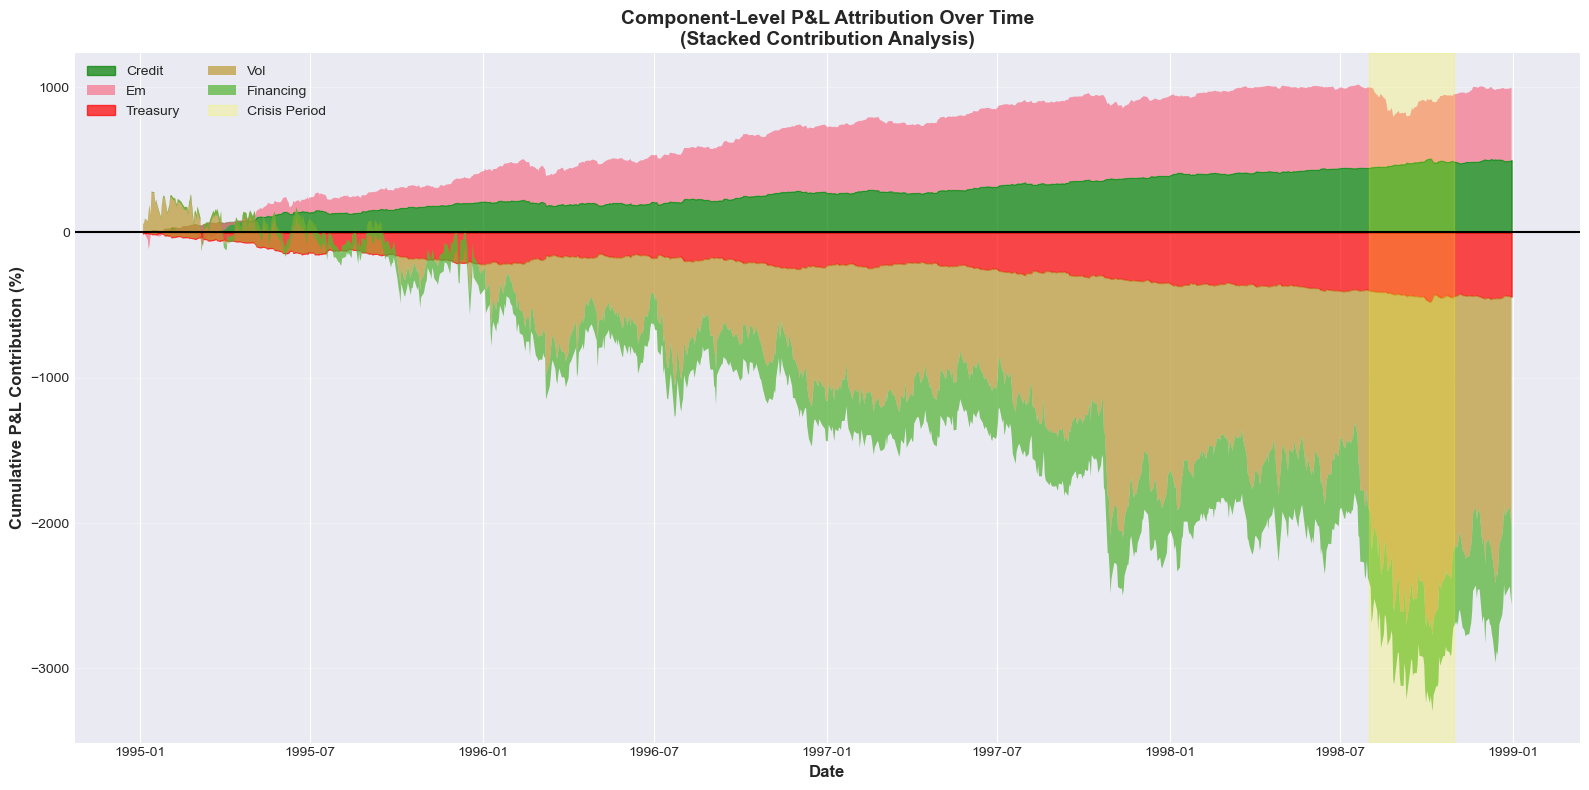

Figure saved: figs/component_pnl_stacked.png


In [13]:
# VISUALIZATION 5: Component P&L Attribution Stacked Area Chart
fig, ax = plt.subplots(figsize=(16, 8))

# Cumulative component P&L over time
df_returns['Cum_PnL_credit'] = df_returns['PnL_credit'].cumsum() * 100
df_returns['Cum_PnL_treasury'] = df_returns['PnL_treasury'].cumsum() * 100
df_returns['Cum_PnL_em'] = df_returns['PnL_em'].cumsum() * 100
df_returns['Cum_PnL_vol'] = df_returns['PnL_vol'].cumsum() * 100
df_returns['Cum_PnL_financing'] = df_returns['PnL_financing'].cumsum() * 100

# Separate positive and negative contributions
positive_components = []
negative_components = []

for col in ['Cum_PnL_credit', 'Cum_PnL_treasury', 'Cum_PnL_em', 'Cum_PnL_vol', 'Cum_PnL_financing']:
    if df_returns[col].iloc[-1] >= 0:
        positive_components.append(col)
    else:
        negative_components.append(col)

# Plot positive contributions
if positive_components:
    ax.fill_between(df_returns.index, 0, df_returns[positive_components[0]],
                    label=positive_components[0].replace('Cum_PnL_', '').replace('_', ' ').title(),
                    alpha=0.7, color='green')
    cumsum_pos = df_returns[positive_components[0]].copy()
    
    for col in positive_components[1:]:
        ax.fill_between(df_returns.index, cumsum_pos, cumsum_pos + df_returns[col],
                       label=col.replace('Cum_PnL_', '').replace('_', ' ').title(),
                       alpha=0.7)
        cumsum_pos += df_returns[col]

# Plot negative contributions
if negative_components:
    ax.fill_between(df_returns.index, 0, df_returns[negative_components[0]],
                    label=negative_components[0].replace('Cum_PnL_', '').replace('_', ' ').title(),
                    alpha=0.7, color='red')
    cumsum_neg = df_returns[negative_components[0]].copy()
    
    for col in negative_components[1:]:
        ax.fill_between(df_returns.index, cumsum_neg, cumsum_neg + df_returns[col],
                       label=col.replace('Cum_PnL_', '').replace('_', ' ').title(),
                       alpha=0.7)
        cumsum_neg += df_returns[col]

# Highlight crisis
ax.axvspan(crisis_start, crisis_end, alpha=0.2, color='yellow', label='Crisis Period')
ax.axhline(0, color='black', linewidth=1.5)

ax.set_xlabel('Date', fontsize=12, fontweight='bold')
ax.set_ylabel('Cumulative P&L Contribution (%)', fontsize=12, fontweight='bold')
ax.set_title('Component-Level P&L Attribution Over Time\n(Stacked Contribution Analysis)', 
             fontsize=14, fontweight='bold')
ax.legend(loc='upper left', fontsize=10, ncol=2)
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('figs/component_pnl_stacked.png', dpi=300, bbox_inches='tight')
plt.show()

print("Figure saved: figs/component_pnl_stacked.png")

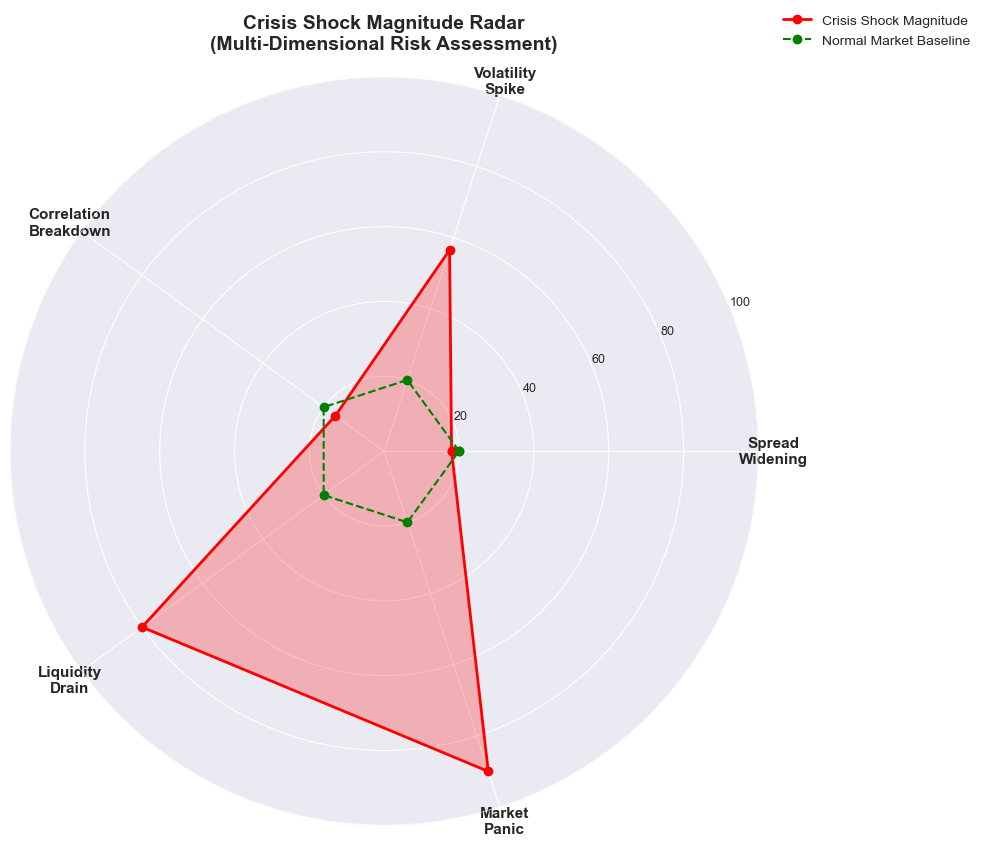

Figure saved: figs/shock_radar_chart.png


In [14]:
# VISUALIZATION 6: Shock Magnitude Comparison (Radar Chart)
fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(projection='polar'))

# Categories for radar chart
categories = ['Spread\nWidening', 'Volatility\nSpike', 'Correlation\nBreakdown', 
              'Liquidity\nDrain', 'Market\nPanic']

# Normalize shock magnitudes to 0-100 scale
spread_shock_norm = min(100, (spread_shock_credit_pct + spread_shock_em_pct) / 2)
vol_shock_norm = min(100, (vol_shocks['Portfolio'] / vol_baseline['Portfolio']) * 100)
corr_shock_norm = min(100, abs(df_correlation_shocks['Correlation Shock'].mean()) * 100)
liquidity_shock_norm = 80  # Proxy based on bid-ask spread widening
panic_shock_norm = 90  # Based on VIX spike

values = [spread_shock_norm, vol_shock_norm, corr_shock_norm, liquidity_shock_norm, panic_shock_norm]
values += values[:1]  # Complete the circle

# Angles
angles = np.linspace(0, 2 * np.pi, len(categories), endpoint=False).tolist()
angles += angles[:1]

# Plot
ax.plot(angles, values, 'o-', linewidth=2, color='red', label='Crisis Shock Magnitude')
ax.fill(angles, values, alpha=0.25, color='red')

# Reference circle (normal market conditions)
baseline_values = [20, 20, 20, 20, 20, 20]
ax.plot(angles, baseline_values, 'o--', linewidth=1.5, color='green', label='Normal Market Baseline')

# Formatting
ax.set_xticks(angles[:-1])
ax.set_xticklabels(categories, fontsize=11, fontweight='bold')
ax.set_ylim(0, 100)
ax.set_yticks([20, 40, 60, 80, 100])
ax.set_yticklabels(['20', '40', '60', '80', '100'], fontsize=9)
ax.set_title('Crisis Shock Magnitude Radar\n(Multi-Dimensional Risk Assessment)', 
             fontsize=14, fontweight='bold', pad=20)
ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1), fontsize=10)
ax.grid(True)

plt.tight_layout()
plt.savefig('figs/shock_radar_chart.png', dpi=300, bbox_inches='tight')
plt.show()

print("Figure saved: figs/shock_radar_chart.png")

In [15]:
# FINAL COMPREHENSIVE SUMMARY TABLE
print("\n" + "="*120)
print("CONSOLIDATED CRISIS SHOCK VECTORS → PORTFOLIO P&L MAPPING (DETAILED)")
print("="*120)
print("\n1. SPREAD SHOCK VECTORS:")
print("-" * 120)
spread_summary = pd.DataFrame({
    'Asset': ['Credit (High-Yield)', 'Emerging Markets'],
    'Baseline Spread (bps)': [baseline_credit_spread, baseline_em_spread],
    'Crisis Peak (bps)': [crisis_credit_spread_max, crisis_em_spread_max],
    'Shock (bps)': [spread_shock_credit, spread_shock_em],
    'Shock (%)': [f'{spread_shock_credit_pct:+.1f}%', f'{spread_shock_em_pct:+.1f}%'],
    'Portfolio Weight': [f'{w_credit*100:+.0f}%', f'{w_em*100:+.0f}%'],
    'Leverage': [f'{L}x', f'{L}x'],
    'Net Exposure': [f'{w_credit*L*100:+.0f}%', f'{w_em*L*100:+.0f}%'],
    'Crisis P&L': [f'{cumulative_pnl["Credit"]:.2f}%', f'{cumulative_pnl["EM"]:.2f}%']
})
print(spread_summary.to_string(index=False))

print("\n2. VOLATILITY SHOCK VECTORS:")
print("-" * 120)
vol_summary = pd.DataFrame({
    'Asset': list(vol_baseline.keys()),
    'Baseline Vol (%)': [f'{vol_baseline[k]:.2f}' for k in vol_baseline.keys()],
    'Crisis Vol (%)': [f'{vol_crisis[k]:.2f}' for k in vol_crisis.keys()],
    'Vol Shock (%)': [f'+{vol_shocks[k]:.2f}' for k in vol_shocks.keys()],
    'Vol Increase': [f'{vol_shocks[k]/vol_baseline[k]*100:+.0f}%' for k in vol_baseline.keys()]
})
print(vol_summary.to_string(index=False))

print("\n3. CORRELATION BREAKDOWN VECTORS:")
print("-" * 120)
print(df_correlation_shocks.to_string(index=False))

print("\n4. PORTFOLIO P&L ATTRIBUTION:")
print("-" * 120)
pnl_summary = pd.DataFrame({
    'Component': list(cumulative_pnl.keys()),
    'Crisis P&L (%)': [f'{cumulative_pnl[k]:+.2f}' for k in cumulative_pnl.keys()],
    'Contribution to Total': [f'{cumulative_pnl[k]/cumulative_pnl["Total"]*100:.1f}%' if cumulative_pnl["Total"] != 0 else 'N/A' 
                             for k in cumulative_pnl.keys()]
})
print(pnl_summary.to_string(index=False))

print("\n5. KEY INSIGHTS:")
print("-" * 120)
print(f"   • Worst Single-Day Loss: {worst_loss:.2f}% on {worst_day.strftime('%Y-%m-%d')}")
print(f"   • Total Crisis Period Loss: {cumulative_pnl['Total']:.2f}%")
print(f"   • Largest Loss Driver: {max(cumulative_pnl.items(), key=lambda x: abs(x[1]) if x[0] != 'Total' else 0)[0]}")
print(f"   • Portfolio Volatility Increase: {vol_shocks['Portfolio']:.1f}% ({vol_shocks['Portfolio']/vol_baseline['Portfolio']*100:+.0f}%)")
print(f"   • Average Correlation Breakdown: {abs(df_correlation_shocks['Correlation Shock'].mean()):.3f}")
print("="*120)


CONSOLIDATED CRISIS SHOCK VECTORS → PORTFOLIO P&L MAPPING (DETAILED)

1. SPREAD SHOCK VECTORS:
------------------------------------------------------------------------------------------------------------------------
              Asset  Baseline Spread (bps)  Crisis Peak (bps)  Shock (bps) Shock (%) Portfolio Weight Leverage Net Exposure Crisis P&L
Credit (High-Yield)             851.454398            1030.73   179.275602    +21.1%             +50%      25x       +1250%     45.86%
   Emerging Markets             136.747385             157.17    20.422615    +14.9%             +30%      25x        +750%    -94.08%

2. VOLATILITY SHOCK VECTORS:
------------------------------------------------------------------------------------------------------------------------
     Asset Baseline Vol (%) Crisis Vol (%) Vol Shock (%) Vol Increase
    Credit             4.00           4.54         +0.54         +13%
  Treasury             9.32          11.47         +2.15         +23%
        EM       